In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import gpytorch
from gpytorch.kernels import MaternKernel, ScaleKernel, \
RBFKernel, CosineKernel
from gpytorch.constraints import Positive

import matplotlib.pyplot as plt
import numpy as np

## Note: 
Define $\sigma: \mathbb{R} \rightarrow (0, \infty)$ and $g: \mathbb{R}^{d \times n} \rightarrow \mathbb{R}^{n \times n}$ by $$\sigma(t) = \frac{e^t}{1+e^t}$$ and $$g(\theta)_{i,j} = \sigma[(\theta^T \theta)_{i,j}]$$


In [3]:
sigmoid = nn.Sigmoid()
logit = torch.special.logit

## **Implementation:** 
Let $\theta \in \mathbb{R}^{d \times n}$. For $t \in \{1, \ldots, T\}$ and $i,j \in \{1, \ldots, n\}$, suppose that $A^{(t)}_{i,j} \overset{\text{iid}}{\sim} \text{Ber}(g(\theta)_{i,j})$ 

In [9]:
def get_up_tri_ind(n, offset=0):
        ind = torch.triu_indices(row=n, col=n, offset=offset)
        
        return ind
    
def get_up_tri(vec, offset=0):
    l = vec.shape[-1]
    n = int((-1 + (1 + 8*l)**.5)/2)
    mat = torch.zeros(n, n)
    ind = get_up_tri_ind(n, offset=offset)
    mat[ind[0], ind[1]] = vec
        
    return mat
        
def get_up_tri_vec(mat, offset=0):
    n = mat.shape[-1]
    vec = torch.zeros(int(n * (n+1) / 2))
    ind = get_up_tri_ind(n, offset=offset)
    vec = mat[ind[0], ind[1]]
        
    return vec

class Orbit(torch.nn.Module):
    # input:
    # eta: 1-dimensional tensor of length l
    #      where l = n+1 choose 2
    
    # output: 
    # instance of class Orbit identified as a vector in R^l
    def __init__(self, eta):
        super(Orbit, self).__init__()
        # length l
        self.l = eta.shape[0]
        # embedding dimension n
        self.n = int((-1 + (1 + 8*l)**.5)/2)
        # vector
        self.orb = torch.nn.Parameter(eta)
        
        return

    def neg_avg_log_like(self, A):
        t = A.shape[-3]
        assert self.n == A.shape[-1]
        assert self.n == A.shape[-2]
        ind = get_up_tri_ind(self.n, offset=1)
        
        up_tri = get_up_tri(self.orb)
        P = sigmoid(up_tri.t() @ up_tri)
        # log likelihood matrix
        llm = A*torch.log(P) + (1-A)*torch.log(1-P)
        #log likelihood vector
        llv = llm[:, ind[0], ind[1]]
        # negative average log likelihood
        nall = -torch.mean(llv)
        
        return nall

    def forward(self, A):
        return self.neg_avg_log_like(A)
    
    def get_orb_norm(self):
        with torch.no_grad():
            orb_norm = torch.linalg.norm(self.orb)
            
        return orb_norm
    
    

In [132]:
# set seed:
torch.manual_seed(0)

# dimensions
n = int(20)
l = int(n * (n+1) / 2)
d = int(100)
t = int(1e3)

# generate data
sig = .1
means = torch.tensor([5.0, -5.0]).reshape((2, 1)).repeat(1, d)
stdvs = torch.tensor(sig).repeat(2,d)
mix = D.Categorical(torch.ones(2,))
comp = D.Independent(D.Normal(means, stdvs), 1)
gmm = D.MixtureSameFamily(mix, comp)

theta0 = gmm.sample((1, n)).reshape((n, d)).t() / torch.tensor(d**.5)

ind = get_up_tri_ind(n)
r0 = torch.linalg.qr(theta0)[1]
eta0 = r0[ind[0], ind[1]]
orb0_norm = torch.linalg.norm(eta0)

P = sigmoid(theta0.t() @ theta0)
P = P.repeat(t, 1, 1)

A = torch.bernoulli(P)
A[:, ind[0], ind[1]] = 0
A = A + torch.transpose(A, 1, 2)

In [133]:
#P

In [134]:
torch.manual_seed(3)

# optimizer
eta = torch.randn(l)
orb = Orbit(eta)
opt = torch.optim.SGD(orb.parameters(), lr=1e-2)

# likelihoods and distances
nalls = []
orb_dists = []

# optimize
num_epochs = 10000
for epoch in range(num_epochs):
    opt.zero_grad()
    nall = orb(A)
    nall.backward()
    opt.step() 

    if epoch % 1000 == 0:
        nalls.append(nall.item())
        orb_norm = orb.get_orb_norm() 
        orb_dist = torch.abs(orb_norm - orb0_norm)
        orb_dists.append(orb_dist)
        print("epoch: %d" %  epoch)
        print("negative average log likelihood: %f" % nall)
        print("orbit distance: %f" % orb_dist)

epoch: 0
negative average log likelihood: 1.143989
orbit distance: nan
epoch: 1000
negative average log likelihood: nan
orbit distance: nan


KeyboardInterrupt: 

tensor(4.3349)

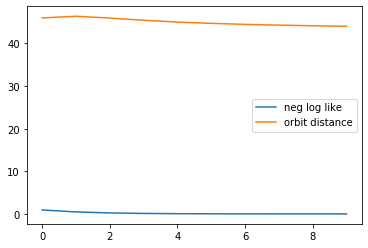

In [122]:
# plots
plt.plot(nalls)
plt.plot(orb_dists)
plt.legend(['neg log like', 'orbit distance'])

with torch.no_grad():
    theta_hat = get_up_tri(orb.orb)

P_hat = sigmoid(theta_hat.t() @ theta_hat)

torch.linalg.norm(P_hat - P)



In [ ]:
theta0_top = torch.randn

In [83]:
torch.manual_seed(0)
mix = D.Categorical(torch.ones(2,))
comp = D.Independent(D.Normal(torch.randn(2,d), torch.rand(2,d)), 1)
gmm = D.MixtureSameFamily(mix, comp)
gmm.sample((1, n)).reshape((n, d))

tensor([[ 1.5503, -0.1517, -2.4217],
        [ 1.5501, -0.0534, -2.1349]])

In [94]:
torch.manual_seed(0)
sig = .1
means = torch.tensor([10.0, -10.0]).reshape((2, 1)).repeat(1, d)
stdvs = torch.tensor(sig).repeat(2,d)
mix = D.Categorical(torch.ones(2,))
comp = D.Independent(D.Normal(means, stdvs), 1)
gmm = D.MixtureSameFamily(mix, comp)

gmm.sample((1, n)).reshape((n, d)).t()

tensor([[-10.1399,  -9.9818],
        [ -9.9597, -10.0857],
        [ -9.9162,  -9.8899]])

### gmm.sample((1, n)).reshape((n, d)).t()

In [71]:
means = torch.tensor([10, -10]).reshape((2, 1)).repeat(1, d)
means

tensor([[ 10,  10,  10],
        [-10, -10, -10]])

In [34]:
import torch.distributions as D
D.normal.Normal

torch.distributions.normal.Normal

In [27]:
A = torch.tensor([[1, 0, 0, 1], [0, 1, 1, 0]]).reshape(2, 2, 2)
A
eta = torch.tensor([1.3, .02, -.4])
orb = Orbit(eta)
U = get_up_tri(eta)
P = sigmoid(U.t() @ U)
P
llm = A*torch.log(P) + (1-A)*torch.log(1-P)
llm
ind = get_up_tri_ind(2, offset=1)
#log likelihood vector
llv = llm[:, ind[0], ind[1]]
llv
# negative average log likelihood
nall = -torch.mean(llv)
nall

tensor([[[1, 0],
         [0, 1]],

        [[0, 1],
         [1, 0]]])

tensor([[0.8442, 0.5065],
        [0.5065, 0.5400]])

tensor([[[-0.1693, -0.7062],
         [-0.7062, -0.6162]],

        [[-1.8593, -0.6802],
         [-0.6802, -0.7766]]])

tensor([[-0.7062],
        [-0.6802]])

tensor(0.6932)

In [23]:
torch.log(torch.tensor(1- .8442))

tensor(-1.8592)

In [9]:
A = torch.tensor([[1,0,0,1], [0,1,1,0,]]).reshape(2, 2, 2)
theta = torch.randn(3, 2)
orb = Orbit(theta)
l = orb.vec.shape[-1]
n = int((-1 + (1 + 8*l)**.5)/2)

t = A.shape[-3]
assert orb.n == A.shape[-1]
assert orb.n == A.shape[-2]
ind = get_up_tri_ind(n, offset=1)
        
up_tri = get_up_tri(orb.vec)
P = sigmoid(up_tri.t() @ up_tri)
# log likelihood matrix
llm = A*torch.log(P) + (1-A)*torch.log(1-P)
#log likelihood vector
llv = llm[:, ind[0], ind[1]]
nall = -torch.mean(llv)







#orb.vec

orb.forward(A)

tensor(0.7428, grad_fn=<NegBackward0>)

In [183]:
llm
llm[0:,:][ind[0], ind[1]]


tensor([[[-0.0204, -0.3022],
         [-0.3022, -0.3985]],

        [[-3.9026, -1.3440],
         [-1.3440, -1.1127]]], grad_fn=<AddBackward0>)

tensor([[-0.3022, -0.3985]], grad_fn=<IndexBackward0>)

In [154]:
A
A.shape[-1:: -1]
A.reshape(A.shape[-3], -1)

tensor([[[1, 0],
         [0, 1]],

        [[1, 1],
         [0, 0]]])

torch.Size([2, 2, 2])

tensor([[1, 0, 0, 1],
        [1, 1, 0, 0]])

In [93]:
theta = torch.randn(2, 5, 3)
d = theta.shape[-2]
n = theta.shape[-1]
assert d >= n
        
upr_tri = torch.linalg.qr(theta)[1]
#upr_tri

ind = torch.triu_indices(row=n, col=n, offset=1)
x = upr_tri[:, ind[0], ind[1]]
x.shape

torch.Size([2, 3])

In [60]:
x.shape[-1]
x.dim()

6

1

In [69]:
sigmoid = nn.Sigmoid()
m = torch.zeros(2,3)
m[[1], [0, 1, 2]] = torch.tensor([1.0,1.0,1.0])
sigmoid(m)

tensor([[0.5000, 0.5000, 0.5000],
        [0.7311, 0.7311, 0.7311]])

In [87]:
P = torch.rand(3, 3)
X = torch.randn(2, 3, 3)
a = X*P
torch.sum(X*P) / 18
torch.mean((X*P))
#X[0,:,:]*P

a.shape

a.reshape((2, 9))[0]
a[0,:,:].reshape((9))

tensor(0.1407)

tensor(0.1407)

torch.Size([2, 3, 3])

tensor([ 0.1564,  0.2282,  0.4826,  0.0667, -0.4289, -0.7223, -0.0926,  1.3388,
         0.4465])

tensor([ 0.1564,  0.2282,  0.4826,  0.0667, -0.4289, -0.7223, -0.0926,  1.3388,
         0.4465])

## **Comparison to MASE:**

In [ ]:
# MASE: 

# Vt_hat = d left leading singular vectors of nxd adj matrix At_hat (use torch.linalg.svd)
# U_hat = nxtd concatenated Vt_hats
# V_hat = d left leading singular vectors of U_hat